<h1 STYLE="padding-left:1em;text-align: center;">Projet 04 : Segmentation des clients d'un site e-commerce Olist </h1> 

#  Introduction  
<p STYLE="padding-left:1em;text-align:justify;">Olist souhaite fournir à ses équipes d'e-commerce une segmentation de ses clients utilisable au quotidien pour leurs campagnes de communication.

<p STYLE="padding-left:1em;text-align:justify;">L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

<p STYLE="padding-left:1em;text-align:justify;">Nous allons fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

<p STYLE="padding-left:1em;text-align:justify;">Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires.

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies et des fonctions graphiques</b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Importation des données et observation des variables pertinentes </b></a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Clustering des clients avec l'algorithme du K-means</b></a><br>
<a href="#3.1" STYLE="padding-left:2em;color:black">3.1 Prepocessor</a><br>
<a href="#3.2" STYLE="padding-left:2em;color:black">3.2 Clustering des clients avec l'algorithme du K-means</a><br>
<a href="#3.2.1" STYLE="padding-left:3em;color:black">3.2.1 Stabilité temporelle : période croissante</a><br>
<a href="#3.2.2" STYLE="padding-left:3em;color:black">3.2.2 Stabilité temporelle : période décroissante</a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et des fonctions graphiques 

In [1]:
%matplotlib inline

from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection

import scipy.stats as stats

from time import time
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.manifold import TSNE, locally_linear_embedding, LocallyLinearEmbedding

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, homogeneity_score, adjusted_mutual_info_score ,davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from scipy.cluster.hierarchy import dendrogram, linkage
from math import radians, cos, sin, asin, sqrt, pi

from sklearn.compose import ColumnTransformer , make_column_transformer
from sklearn.pipeline import Pipeline , make_pipeline
from joblib import parallel_backend, Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

<p STYLE="padding-left:1em;color:blue;"><b>Configuration générale des différents graphiques <font>

In [2]:
plt.rcdefaults()
font_title = {'color': 'blue','weight': 'bold','size': 14}
font_label = {'size': 12}
font_ticks = 12
font_legend = 10

c = []
[c.append(plt.cm.tab20(i)) for i in range(20)]
c20 = []
[c20.append(plt.cm.tab10(i)) for i in range(10)]
[c20.append(plt.cm.Pastel1(i)) for i in range(9)]

def config_plt(plot = plt, ax = None, title = 'titre', X_name = 'x' , Y_name = 'y' , legend = ''):
    if plot == plt :
        plot.title(title,fontdict=font_title)
        plot.xlabel(X_name,fontdict=font_label)
        plot.ylabel(Y_name,fontdict=font_label)
        plot.xticks(fontsize =font_ticks)
        plot.yticks(fontsize =font_ticks)
        if legend is not None:
            plot.legend(title = legend , fontsize =font_legend)
    else : 
# Sub-plot
        ax.set_title(title,fontdict=font_title)
        ax.set_xlabel(X_name,fontdict=font_label)
        ax.set_ylabel(Y_name,fontdict=font_label)
        ax.tick_params(axis='x', labelsize=font_ticks)
        ax.tick_params(axis='y', labelsize=font_ticks)
        if legend is not None: 
            ax.legend(title = legend , fontsize =font_legend)

In [3]:
def plot_(DF, x_cols,cols, categorie= None,Nb_cols=2,marker = '',length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = round(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length))    
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.plot(DF[x_cols[0]],DF[cols[i]],color = c[0],marker = marker)
            else : 
                axes.plot(DF[x_cols[i]],DF[cols[i]],color = c[0],marker = marker)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.plot(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],marker = marker,label = cat)
                else : 
                    axes.plot(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],marker = marker, label = cat)
                k+=1
#             legend = str(cat if label.get(cat) is None else label.get(cat))
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        axes.grid(visible=True,axis='x')

        x_ticks = DF[x_cols[0]][DF[x_cols[0]]%2==0]
        axes.set_xticks(x_ticks) if axes is not plt else axes.xticks(x_ticks) if DF[x_cols[0]].size<=15 else None 
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else [title if len([cols]) == 1 else title[i]]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        fig.tight_layout()
    plt.show() 

def plot_scatter(DF, x_cols,cols, categorie= None,Nb_cols=2,length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None
                 ,y_name=None,legend=None):
    
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = round(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length)) 
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.scatter(DF[x_cols[0]],DF[cols[i]],color = c[0],s=1.75)
            else : 
                axes.scatter(DF[x_cols[i]],DF[cols[i]],color = c[0],s=1.75)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.scatter(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],s=1.75 ,label = cat)
                else : 
                    axes.scatter(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],s=1.75, label = cat)
                k+=1
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else title if len([cols]) == 1 else title[i]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
    fig.tight_layout()
    plt.show() 

def plot_bar(DF, x_cols, y_cols = None , Nb_cols=2,height=None,width=None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols]  if np.array([x_cols]).size == 1 else x_cols
    y_cols = None if y_cols is None else [y_cols] if np.array([y_cols]).size == 1 else y_cols  
    Nb_var= (1 if len(x_cols)==1 else len(x_cols)) if y_cols is None else len(y_cols) if len(y_cols) > 1 else 1  
    
    Nb_row = int(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    height = 4*Nb_row if height is None else height
    fig = plt.figure(figsize=(width,height)) 

    for i in range(0,Nb_var):
        cols = x_cols[i] if y_cols is None else x_cols[0]
        if (DF[cols].nunique()>16) & (DF[cols].dtypes == object) & (Nb_cols == 1):
            width = min(DF[cols].nunique()/4,30) 
            fig = plt.figure(figsize=(width,height))
        elif (Nb_cols == 1) :
            width = 4*Nb_cols 
            fig = plt.figure(figsize=(width,height))
        elif (DF[cols].nunique()>16) & (DF[cols].dtypes == object) & ( Nb_cols > 1) :
            width = min(DF[cols].nunique()*Nb_cols/4,30)
            fig.set_figwidth(width)
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1) if Nb_cols>1 else plt
        if y_cols is None :
            count = DF.groupby(by=DF[cols])[cols].count().sort_values(ascending = False)
            X = count.index.values
            Y = count.values
        else :
            X = DF.groupby(cols).agg({ y_cols[i] : 'sum'}).reset_index().iloc[:,0]
            Y = DF.groupby(cols).agg({ y_cols[i] : 'sum'}).reset_index().iloc[:,1]
            
        if title is None :
            titre = cols if y_cols is None else y_cols[i]
            title_plt = 'Distribution :\n ' + str(titre if label.get(titre) is None else label.get(titre))
        else : 
            title_plt = title if np.array([cols]).size == 1 else title[i]
        if x_name is None :
            x_nom = cols if y_cols is None else cols
            x = str(x_nom if label.get(x_nom) is None else label.get(x_nom))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[i]
        if y_name is None : 
            y_nom = cols if y_cols is None else y_cols[i]
            y = 'Nombre de '+ str(y_nom if label.get(y_nom) is None else label.get(y_nom))  
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
        
        #plot bar
        if len(X)<=20 : 
            axes.bar(X,Y,color=c[0 : len(X)])        
            for j in range(0,len(X)):
                j = int(j)
                axes.bar(X,Y,width=0,color= c[j],label= X[j])
        else : 
            axes.bar(X,Y,color=c[0])
            
        (axes.set_xticks(X) if axes is not plt else axes.xticks(X)) if X.size<=12 else None   
        axes.tick_params(axis='x',rotation = 90)
        config_plt(plot = axes, ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
    plt.tight_layout()
    plt.show()   

# <a STYLE="color:black" id="2">Etape 2 : Importation des données et observation des variables 

In [4]:
Data_customer= pd.read_csv('P04_Data_customer.csv')
Data_orders = pd.read_csv('P04_Data_orders.csv')
t_debut = time()

In [5]:
def info_df(dict_df):
    liste_df =[]
    liste_cols = []
    liste_unique = []
    Nb_valeurs = []
    Nb_nuls = []
    Nb_doublons = []
    i = 0
    for nom_df, df in dict_df.items() : 
        for col in df.columns :
            liste_df.append(nom_df)
            liste_cols.append(col)
            Nb_valeurs.append(df[col].shape[0])
            Nb_nuls.append(df[col].isnull().sum())
            try :
                liste_unique.append(df[col].nunique())
                Nb_doublons.append(df[df.duplicated(subset=col)].shape[0])
            except :
                flatten = [val for sublist in df[col].to_list() if sublist is not np.nan for val in sublist ]
                df_flatten = pd.DataFrame([sublist[0] for sublist in flatten], columns = ['liste'])
                liste_unique.append(df_flatten['liste'].nunique())
                Nb_doublons.append(df_flatten[df_flatten.duplicated(subset='liste')].shape[0])       

    info_data = pd.DataFrame(np.array([liste_df,liste_cols,liste_unique,Nb_valeurs,Nb_nuls,Nb_doublons]).T, 
                             columns = ['Nom Data','Nom cols','Valeurs uniques','Nb valeurs', 'Nb valeurs nuls','Nb doublons'])
    return info_data

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Informations générales des différents jeux de données

In [6]:
display(info_df({'Data_customer' :Data_customer }))
Data_customer.info()
Data_customer.describe()

,Nom Data,Nom cols,Valeurs uniques,Nb valeurs,Nb valeurs nuls,Nb doublons
0,Data_customer,customer_unique_id,93357,93357,0,0
1,Data_customer,total_money_spent,27869,93357,0,65488
2,Data_customer,mean_money_spent,28074,93357,0,65283
3,Data_customer,date_of_last_purchase,610,93357,0,92747
4,Data_customer,Nb_of_purchases,9,93357,0,93348
5,Data_customer,mean_review_score,27,93357,0,93330
6,Data_customer,mean_payment_sequential,31,93357,0,93326
7,Data_customer,mean_payment_installments,75,93357,0,93282
8,Data_customer,mean_order_item_per_purchage,39,93357,0,93318
9,Data_customer,customer_state,27,93357,0,93330


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              93357 non-null  object 
 1   total_money_spent               93357 non-null  float64
 2   mean_money_spent                93357 non-null  float64
 3   date_of_last_purchase           93357 non-null  int64  
 4   Nb_of_purchases                 93357 non-null  int64  
 5   mean_review_score               93357 non-null  float64
 6   mean_payment_sequential         93357 non-null  float64
 7   mean_payment_installments       93357 non-null  float64
 8   mean_order_item_per_purchage    93357 non-null  float64
 9   customer_state                  93357 non-null  object 
 10  health_beauty                   93357 non-null  float64
 11  culture                         93357 non-null  float64
 12  sports_leisure                  

,total_money_spent,mean_money_spent,date_of_last_purchase,Nb_of_purchases,mean_review_score,mean_payment_sequential,mean_payment_installments,mean_order_item_per_purchage,health_beauty,culture,sports_leisure,toys_baby,home_furniture,flowers_gifs_stuff,construction_tools,technology,fashion_accessory,auto,commerce,others,security_services_signaling,industry_commerce_and_business,food_drink,market_place,credit_card,boleto,voucher,debit_card
count,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000
mean,165.198772,160.316648,236.936673,1.033420,4.128007,1.043859,2.965011,1.139511,0.133160,0.020485,0.086672,0.073440,0.365738,0.100328,0.021018,0.174713,0.037020,0.043334,0.047918,0.016179,0.002060,0.002773,0.011476,0.003197,0.773054,0.199188,0.056116,0.015501
std,226.314579,219.572062,152.584315,0.209099,1.318213,0.363318,2.716192,0.527042,0.387012,0.151123,0.321597,0.283029,0.661735,0.325475,0.181361,0.452297,0.205715,0.232480,0.241359,0.141870,0.064246,0.059603,0.130534,0.066335,0.424950,0.398598,0.402715,0.123116
min,9.590000,9.590000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.060000,62.370000,113.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,107.780000,105.630000,218.000000,1.000000,5.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,182.560000,176.650000,345.000000,1.000000,5.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,13664.080000,13664.080000,694.000000,15.000000,5.000000,26.000000,26.000000,21.000000,21.000000,4.000000,7.000000,12.000000,15.000000,12.000000,10.000000,20.000000,6.000000,20.000000,7.000000,6.000000,6.000000,4.000000,10.000000,6.000000,2.000000,1.000000,25.000000,2.000000


In [7]:
display(info_df({'Data_orders' :Data_orders }))
Data_orders.info()

,Nom Data,Nom cols,Valeurs uniques,Nb valeurs,Nb valeurs nuls,Nb doublons
0,Data_orders,customer_id,96477,96477,0,0
1,Data_orders,customer_unique_id,93357,96477,0,3120
2,Data_orders,customer_state,27,96477,0,96450
3,Data_orders,order_id,96477,96477,0,0
4,Data_orders,order_status,1,96477,0,96476
5,Data_orders,order_purchase_timestamp,95955,96477,0,522
6,Data_orders,order_delivered_customer_date,95657,96477,8,819
7,Data_orders,Nb_payment_sequential,19,96477,0,96458
8,Data_orders,Sum_payment_installments,27,96477,0,96450
9,Data_orders,type_payment_use,41,96477,0,96436


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       96477 non-null  object 
 1   customer_unique_id                96477 non-null  object 
 2   customer_state                    96477 non-null  object 
 3   order_id                          96477 non-null  object 
 4   order_status                      96477 non-null  object 
 5   order_purchase_timestamp          96477 non-null  object 
 6   order_delivered_customer_date     96469 non-null  object 
 7   Nb_payment_sequential             96477 non-null  int64  
 8   Sum_payment_installments          96477 non-null  float64
 9   type_payment_use                  96477 non-null  object 
 10  Sum_payment_value                 96477 non-null  float64
 11  boleto                            96477 non-null  float64
 12  cred

In [8]:
Data_customer.drop(['total_money_spent'] ,axis = 1, inplace =True , errors = 'ignore')
display(Data_customer.describe())
display(Data_customer)

,mean_money_spent,date_of_last_purchase,Nb_of_purchases,mean_review_score,mean_payment_sequential,mean_payment_installments,mean_order_item_per_purchage,health_beauty,culture,sports_leisure,toys_baby,home_furniture,flowers_gifs_stuff,construction_tools,technology,fashion_accessory,auto,commerce,others,security_services_signaling,industry_commerce_and_business,food_drink,market_place,credit_card,boleto,voucher,debit_card
count,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000
mean,160.316648,236.936673,1.033420,4.128007,1.043859,2.965011,1.139511,0.133160,0.020485,0.086672,0.073440,0.365738,0.100328,0.021018,0.174713,0.037020,0.043334,0.047918,0.016179,0.002060,0.002773,0.011476,0.003197,0.773054,0.199188,0.056116,0.015501
std,219.572062,152.584315,0.209099,1.318213,0.363318,2.716192,0.527042,0.387012,0.151123,0.321597,0.283029,0.661735,0.325475,0.181361,0.452297,0.205715,0.232480,0.241359,0.141870,0.064246,0.059603,0.130534,0.066335,0.424950,0.398598,0.402715,0.123116
min,9.590000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.370000,113.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,105.630000,218.000000,1.000000,5.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,176.650000,345.000000,1.000000,5.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,13664.080000,694.000000,15.000000,5.000000,26.000000,26.000000,21.000000,21.000000,4.000000,7.000000,12.000000,15.000000,12.000000,10.000000,20.000000,6.000000,20.000000,7.000000,6.000000,6.000000,4.000000,10.000000,6.000000,2.000000,1.000000,25.000000,2.000000


,customer_unique_id,mean_money_spent,date_of_last_purchase,Nb_of_purchases,mean_review_score,mean_payment_sequential,mean_payment_installments,mean_order_item_per_purchage,customer_state,health_beauty,culture,sports_leisure,toys_baby,home_furniture,flowers_gifs_stuff,construction_tools,technology,fashion_accessory,auto,commerce,others,security_services_signaling,industry_commerce_and_business,food_drink,market_place,credit_card,boleto,voucher,debit_card
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,111,1,5.0,1.0,8.0,1.0,SP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,114,1,4.0,1.0,1.0,1.0,SP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,86.22,536,1,3.0,1.0,8.0,1.0,SC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,320,1,4.0,1.0,4.0,1.0,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,196.89,287,1,5.0,1.0,6.0,1.0,SP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,446,1,5.0,1.0,10.0,2.0,PE,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
93353,fffea47cd6d3cc0a88bd621562a9d061,84.58,261,1,4.0,1.0,1.0,1.0,BA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
93354,ffff371b4d645b6ecea244b27531430a,112.46,567,1,5.0,1.0,1.0,1.0,MT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
93355,ffff5962728ec6157033ef9805bacc48,133.69,118,1,5.0,1.0,5.0,1.0,ES,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
Data_orders['order_purchase_timestamp'] = pd.to_datetime(Data_orders['order_purchase_timestamp'])
display(Data_orders)

,customer_id,customer_unique_id,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,Nb_payment_sequential,Sum_payment_installments,type_payment_use,Sum_payment_value,boleto,credit_card,debit_card,voucher,Nb_product_id,Nb_product_category_name_english,Nb_order_item_id,Reduce_product_cat_name,health_beauty,culture,sports_leisure,toys_baby,home_furniture,flowers_gifs_stuff,construction_tools,technology,fashion_accessory,auto,commerce,others,security_services_signaling,industry_commerce_and_business,food_drink,market_place,review_id,review_score_max,comment_message,year_purchase,month_purchase,day_purchase,hour_purchase,delivery_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,1,2.0,"[('credit_card', 1)]",146.87,0.0,1.0,0.0,0.0,"[('a9516a079e37a9c9c36b9b78b10169e8', 1)]","[('office_furniture', 1)]",1.0,home_furniture,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88b8b52d46df026a9d1ad2136a59b30b,4.0,0.0,2017,5,Tuesday,15,8.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,1,8.0,"[('credit_card', 1)]",335.48,0.0,1.0,0.0,0.0,"[('4aa6014eceb682077f9dc4bffebc05b0', 1)]","[('housewares', 1)]",1.0,home_furniture,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,0.0,2018,1,Friday,20,16.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,1,7.0,"[('credit_card', 1)]",157.73,0.0,1.0,0.0,0.0,"[('bd07b66896d6f1494f5b86251848ced7', 1)]","[('office_furniture', 1)]",1.0,home_furniture,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5ad6695d76ee186dc473c42706984d87,5.0,0.0,2018,5,Saturday,16,26.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,1,1.0,"[('credit_card', 1)]",173.30,0.0,1.0,0.0,0.0,"[('a5647c44af977b148e0a3a4751a09e2e', 1)]","[('office_furniture', 1)]",1.0,home_furniture,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,059a801bb31f6aab2266e672cab87bc5,5.0,0.0,2018,3,Tuesday,16,14.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,1,8.0,"[('credit_card', 1)]",252.25,0.0,1.0,0.0,0.0,"[('9391a573abe00141c56e38d84d7d5b3b', 1)]","[('home_confort', 1)]",1.0,home_furniture,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8490879d58d6c5d7773f2739a03f089a,5.0,1.0,2018,7,Sunday,9,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96472,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,1,6.0,"[('credit_card', 1)]",88.78,0.0,1.0,0.0,0.0,"[('ccb4503d9d43d245d3b295d0544f988b', 1)]","[('books_general_interest', 1)]",1.0,culture,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36e2cdbaa9f639b57c53b37ac798fee8,4.0,0.0,2018,4,Saturday,15,6.0
96473,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,1,3.0,"[('credit_card', 1)]",129.06,0.0,1.0,0.0,0.0,"[('9ede6b0570a75a4b9de4f383329f99ee', 1)]","[('sports_leisure', 1)]",1.0,sports_leisure,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b273b431c3aedb4eed18643309652940,5.0,0.0,2018,4,Wednesday,8,7.0
96474,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,1,5.0,"[('credit_card'

# <a STYLE="color:black" id="3">Etape 3 : Clustering des clients avec l'algorithme du K-means
## <a STYLE="color:black" id="3.1">3.1 Preprocessor</a> 

In [10]:
cols_payment_type = ['credit_card','boleto','voucher','debit_card']
cols_cat_product = ['health_beauty','culture','sports_leisure','toys_baby','home_furniture','flowers_gifs_stuff',
                'construction_tools','technology','auto','fashion_accessory','commerce','others','security_services_signaling',
                'industry_commerce_and_business','food_drink','market_place']
cols_cat_state = list(Data_customer['customer_state'].unique())


cols_cat = list(Data_customer.select_dtypes(exclude=['int64', 'float64']).columns.drop('customer_unique_id', errors = 'ignore' ))
cols_var = list(Data_customer.select_dtypes(include=['int64', 'float64']).columns)

In [11]:
scaler = MinMaxScaler()
scaler_std = StandardScaler()
scaler_enc = OneHotEncoder()

preprocessor = ColumnTransformer([('minmax',scaler ,cols_var),
                                  ('OHE',scaler_enc, cols_cat)])

In [12]:
def cols_transform(X , transform) :
    try :
        X_reduce = transform.fit_transform(X)
    except : 
        X_reduce = transform.fit_transform(X).toarray()
    X_reduce = pd.DataFrame(X_reduce,index = X.index, columns = transform.get_feature_names_out() )

    label = {x : x.replace('std__','').replace('minmax__','').replace('OHE__customer_state_','') for x in X_reduce.columns}
    X_reduce.rename(label, axis = 1, inplace =True)
    return X_reduce

In [13]:
def period_customer(init = 12, interval = 2, transform = None, ascending = True):
    min_time = Data_orders['order_purchase_timestamp'].min()
    max_time = Data_orders['order_purchase_timestamp'].max()
    start = min_time + pd.DateOffset(months=init) if ascending==True else max_time  
    times = start + pd.DateOffset(months=interval)  
    
    Data_select = Data_orders.copy()
    Data_select = Data_select[Data_select['order_purchase_timestamp']<=times]
    
    Data_deltatime = Data_select.groupby(by='customer_unique_id').agg({'Sum_payment_value' : 'mean',
                                                                       'order_purchase_timestamp':['min','max'],
                                                                       'customer_id' : 'count',
                                                                       'review_score_max':'mean',
                                                                       'Nb_payment_sequential':'mean',
                                                                       'Sum_payment_installments':'mean',
                                                                       'Nb_order_item_id':'mean'}).reset_index()

    Data_deltatime.columns = ['customer_unique_id','mean_money_spent','date_of_first_purchase','date_of_last_purchase',
                             'Nb_of_purchases','mean_review_score','mean_payment_sequential','mean_payment_installments',
                             'mean_order_item_per_purchage']
    
    Data_deltatime['date_of_last_purchase']=(Data_deltatime['date_of_last_purchase'].max()-Data_deltatime['date_of_last_purchase']).dt.days

    Data_deltatime_cat = Data_select.groupby(by='customer_unique_id')[cols_cat_product].agg('mean')
    Data_deltatime_payment = Data_select.groupby(by='customer_unique_id')[cols_payment_type].agg('mean')
    Data_deltatime_state = Data_select.drop_duplicates(subset='customer_unique_id',keep='first')[['customer_unique_id','customer_state']]

    Data_deltatime = pd.merge(Data_deltatime,Data_deltatime_state, how = 'outer', on ='customer_unique_id')
    Data_deltatime = pd.merge(Data_deltatime,Data_deltatime_cat, how = 'outer', on ='customer_unique_id')
    Data_deltatime = pd.merge(Data_deltatime,Data_deltatime_payment, how = 'outer', on ='customer_unique_id')
    Data_deltatime['mean_review_score'].fillna(0, inplace = True)
    Data_deltatime.set_index('customer_unique_id',inplace=True)
    
    Data_deltatime.drop('date_of_first_purchase',axis = 1,inplace = True, errors = 'ignore')
    
    Data_deltatime = Data_deltatime if transform is None else cols_transform(Data_deltatime,transform)
    
    return Data_deltatime

## <a STYLE="color:black" id="3.2">3.2 Clustering des clients avec l'algorithme du K-Means</a>
## <a STYLE="padding-left:1em;color:black" id="3.2.1">3.2.1 Stabilité temporelle : période croissante</a>

In [14]:
from joblib import Memory

location = './cachedir_maintenance/'
mem = Memory(location,mmap_mode='r+',verbose=0)
mem.clear(warn=False)

In [15]:
@mem.cache
def KMeans_clusters(X,num_clusters, random_state):
    cls = Pipeline([('KMeans',KMeans(n_clusters=num_clusters, random_state=random_state,n_init=1))])
    cls.fit(X)
    inertie = cls.named_steps['KMeans'].inertia_
    cluster_labels = cls.named_steps['KMeans'].labels_
    silhouettes_avg = silhouette_score(X,cluster_labels,random_state=random_state,sample_size=X.sample(frac=0.1).shape[0])
    davies_bouldin = davies_bouldin_score(X,cluster_labels)
    
    return num_clusters,inertie,silhouettes_avg,davies_bouldin,cluster_labels , X

def KMeans_parallel(X,list_clusters, score = True , random_state = 0) : 
    resultat = Parallel(n_jobs=-1)(delayed(KMeans_clusters)(X,num_clusters,random_state) for num_clusters in list_clusters)
    n_clusters , inertie , silhouettes_avg,davies_bouldin, cluster_labels,X = zip(*resultat)
    if score == True :
        score_cls = pd.DataFrame(np.array([n_clusters,silhouettes_avg,inertie,davies_bouldin]).T,
                                 columns = ['n_clusters','silhouettes_avg','inertie','davies_bouldin'])
        plot_(score_cls, 'n_clusters',['silhouettes_avg','inertie','davies_bouldin'],marker = 'o',Nb_cols=3)  

def data_clusters(X , n_clusters):
    X_cls = X.copy()
    cls = Pipeline([('KMeans',KMeans(n_clusters=n_clusters, random_state=0,n_init=1))]) 
    cls.fit(X)
    X_cls['kmeans_label'] = cls.named_steps['KMeans'].labels_
    return X_cls 

In [16]:
def period_kmeans(n_clusters,init = 12, period = 2,transform = None, ascending = True,random_state=0) :
    min_time = Data_orders['order_purchase_timestamp'].min()
    max_time = Data_orders['order_purchase_timestamp'].max()
    start = min_time + pd.DateOffset(months=init) if ascending ==True else max_time    
    stop = (max_time - start)/np.timedelta64(1,'M')
    stop = int(stop+2) if int(stop)%period==0 else int(stop+1)
    
    liste_period = list(range(0,stop+period,period)) if ascending ==True else list(range(0,-init-period,-period))
    resultat=Parallel(n_jobs=-1)(delayed(KMeans_clusters)(period_customer(init=init,interval=i,transform=transform,ascending=ascending),n_clusters,random_state=random_state) for i in liste_period)
    n_clusters , inertie,silhouettes_avg, davies_bouldin, cluster_labels, DF = zip(*resultat)
    
    data_init = DF[0]
    data_init['labels_init'] = cluster_labels[0]
    Y_labels_init = data_init['labels_init']
    
    homo,ARI,AMI, clusters_modified  = [],[],[],[]
    for i, j in enumerate(n_clusters):
        data_period = DF[i]
        data_period['labels_period'] = cluster_labels[i]
        Y_labels_period = data_period['labels_period']
        Y_labels_period = pd.merge(Y_labels_init,Y_labels_period,how = 'inner', on = 'customer_unique_id')
        clusters_change = Y_labels_period[Y_labels_period['labels_init']!=Y_labels_period['labels_period']].shape[0]*100/Y_labels_period.shape[0]        
        
        clusters_modified.append(clusters_change)
        homo.append(homogeneity_score(Y_labels_period.iloc[:,0].values, Y_labels_period.iloc[:,1].values ))
        ARI.append(adjusted_rand_score(Y_labels_period.iloc[:,0].values, Y_labels_period.iloc[:,1].values ))
        AMI.append(adjusted_mutual_info_score(Y_labels_period.iloc[:,0].values,Y_labels_period.iloc[:,1].values ))
    
    score_cls = pd.DataFrame(np.array([liste_period,homo,ARI,AMI,clusters_modified]).T,
                             columns = ['periodes','homogeneity','ARI','AMI', '% clusters changed'])                             
    plot_(score_cls,'periodes',['homogeneity','ARI','AMI'],marker = 'o',Nb_cols=3)  
    
    return Y_labels_period

In [17]:
cols_var =list(Data_customer.select_dtypes(include=['int64','float64']).columns )
preprocessor_less_cat = ColumnTransformer([('minmax',scaler ,cols_var),( 'OHE', scaler_enc,cols_cat )])

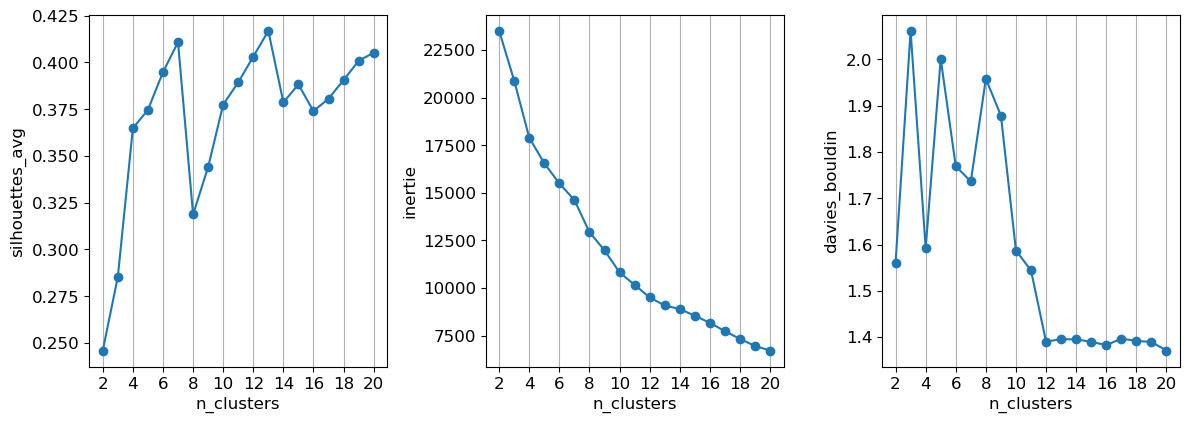

10.729770421981812


,mean_money_spent,date_of_last_purchase,Nb_of_purchases,mean_review_score,mean_payment_sequential,mean_payment_installments,mean_order_item_per_purchage,health_beauty,culture,sports_leisure,toys_baby,home_furniture,flowers_gifs_stuff,construction_tools,technology,fashion_accessory,auto,commerce,others,security_services_signaling,industry_commerce_and_business,food_drink,market_place,credit_card,boleto,voucher,debit_card,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO,kmeans_label
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,0.005577,0.565934,0.0,0.6,0.0,0.28,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7
0005e1862207bf6ccc02e4228effd9a0,0.010257,0.582418,0.0,0.8,0.0,0.08,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0006fdc98a402fceb4eb0ee528f6a8d4,0.001386,0.211538,0.0,0.6,0.0,0.04,0.00,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
000a5ad9c4601d2bbdd9ed765d5213b3,0.005948,0.142857,0.0,0.8,0.0,0.08,0.00,0.047619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
000bfa1d2f1a41876493be685390d6d3,0.002694,0.008242,0.0,1.0,0.0,0.12,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,0.006787,0.142857,0.0,1.0,0.0,0.04,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
fff699c184bcc967d62fa2c6171765f7,0.003291,0.085165,0.0,0.8,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5
fffcf5a5ff07b0908bd4e2dbc735a684,0.150677,0.318681,0.0,1.0,0.0,0.36,0.05,0.095238,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [18]:
X_init_transform = period_customer(init = 12,interval = 0, transform = preprocessor_less_cat, ascending = True)
t0 = time()
list_clusters = list(range(2,21))
KMeans_parallel(X_init_transform,list_clusters,score=True) 
print(time() - t0)
data_init = data_clusters(X_init_transform , 8)
data_init

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous avons effectué un balayage du nombre de cluster avec l'algorithme du K-means avec le jeu de données amputé des clients et commandes ayant effectués des achats dans les 12 derniers mois par rapport à la date du dernier achat de la base de donnée. Ce balayage montre qu'un nombre de 13 clusters offrent les meilleurs scores, soit 2 de plus que dans l'étude effectuée avec la globalité de la base de donnée.    

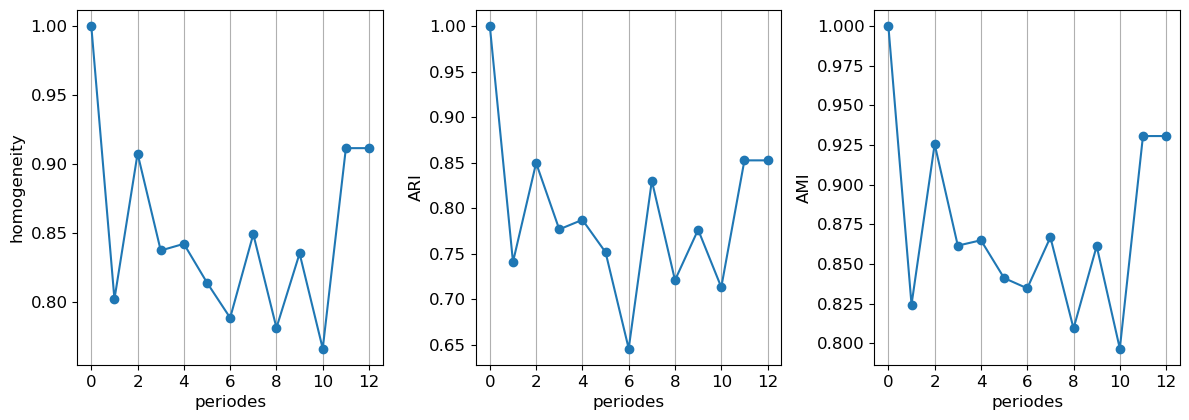

,labels_init,labels_period
customer_unique_id,,
0000f46a3911fa3c0805444483337064,9,7
0005e1862207bf6ccc02e4228effd9a0,1,0
0006fdc98a402fceb4eb0ee528f6a8d4,7,10
000a5ad9c4601d2bbdd9ed765d5213b3,3,6
000bfa1d2f1a41876493be685390d6d3,4,1
...,...,...
fff3a9369e4b7102fab406a334a678c3,7,10
fff699c184bcc967d62fa2c6171765f7,5,4
fffcf5a5ff07b0908bd4e2dbc735a684,7,10


In [19]:
period_kmeans(n_clusters = 11,init = 12, period = 1, transform = preprocessor_less_cat,ascending = True)

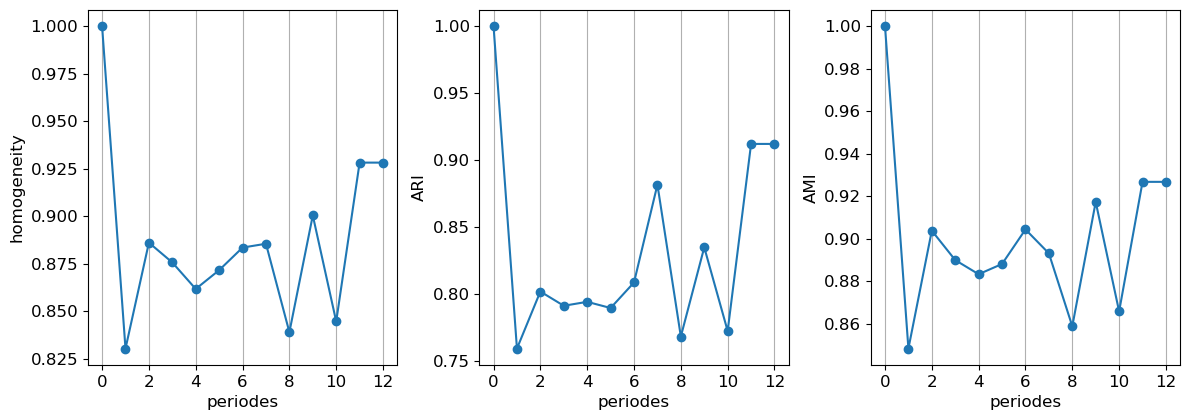

,labels_init,labels_period
customer_unique_id,,
0000f46a3911fa3c0805444483337064,9,11
0005e1862207bf6ccc02e4228effd9a0,1,0
0006fdc98a402fceb4eb0ee528f6a8d4,7,11
000a5ad9c4601d2bbdd9ed765d5213b3,11,6
000bfa1d2f1a41876493be685390d6d3,4,1
...,...,...
fff3a9369e4b7102fab406a334a678c3,7,11
fff699c184bcc967d62fa2c6171765f7,5,4
fffcf5a5ff07b0908bd4e2dbc735a684,7,10


In [20]:
period_kmeans(n_clusters = 13,init = 12, period = 1, transform = preprocessor_less_cat,ascending = True)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous avons calculé la stabilité des segments à partir de 12 mois avant le dernier achat et par pas de 1 mois. Nous observons une baisse de la stabilité des segments au bout d'un mois pour 11 et 13 clusters sélectionnés.    

## <a STYLE="padding-left:1em;color:black" id="3.2.2">3.2.2 Stabilité temporelle : période décroissante</a>

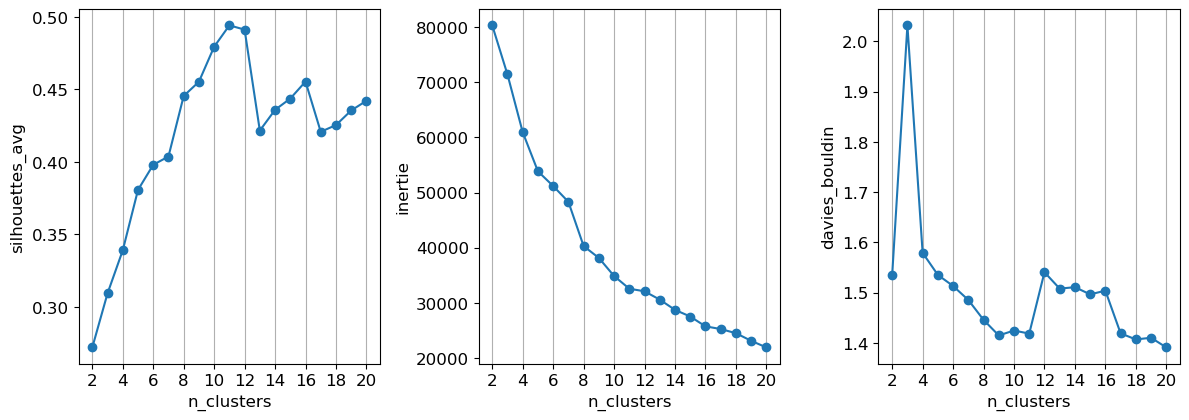

31.867286443710327


,mean_money_spent,date_of_last_purchase,Nb_of_purchases,mean_review_score,mean_payment_sequential,mean_payment_installments,mean_order_item_per_purchage,health_beauty,culture,sports_leisure,toys_baby,home_furniture,flowers_gifs_stuff,construction_tools,technology,fashion_accessory,auto,commerce,others,security_services_signaling,industry_commerce_and_business,food_drink,market_place,credit_card,boleto,voucher,debit_card,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO,kmeans_label
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.009690,0.159942,0.0,1.0,0.0,0.307692,0.00,0.000000,0.0,0.0,0.000000,0.066667,0.000000,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,0.001289,0.164265,0.0,0.8,0.0,0.038462,0.00,0.047619,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
0000f46a3911fa3c0805444483337064,0.005612,0.772334,0.0,0.6,0.0,0.307692,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.00,0.142857,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7
0000f6ccb0745a6a4b88665a16c9f078,0.002492,0.461095,0.0,0.8,0.0,0.153846,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.05,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
0004aac84e0df4da2b147fca70cf8255,0.013717,0.413545,0.0,1.0,0.0,0.230769,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.05,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.150707,0.642651,0.0,1.0,0.0,0.384615,0.05,0.095238,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
fffea47cd6d3cc0a88bd621562a9d061,0.005492,0.376081,0.0,0.8,0.0,0.038462,0.00,0.000000,0.0,0.0,0.083333,0.000000,0.000000,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
ffff371b4d645b6ecea244b27531430a,0.007534,0.817003,0.0,1.0,0.0,0.038462,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.05,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10


In [21]:
X_init_2_transform = period_customer(init = 12,interval = 0, transform = preprocessor_less_cat, ascending = False)
t0 = time()
list_clusters = list(range(2,21))
KMeans_parallel(X_init_2_transform,list_clusters,score=True) 
print(time() - t0)
data_init = data_clusters(X_init_2_transform , 11)
data_init

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous avons effectué un balayage du nombre de cluster avec l'algorithme du K-means avec le jeu de données entier. Ce balayage montre qu'un nombre de 11 clusters offrent les meilleurs scores.    

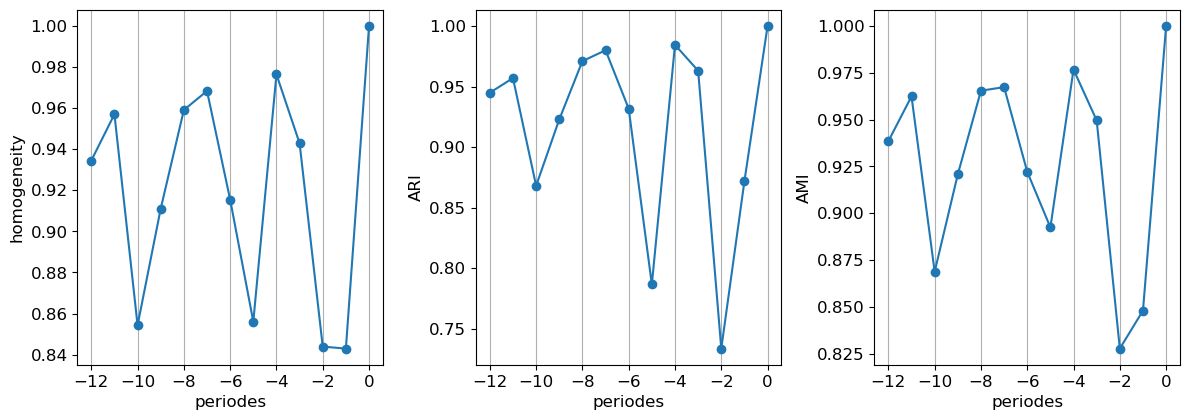

,labels_init,labels_period
customer_unique_id,,
0000f46a3911fa3c0805444483337064,7,7
0005e1862207bf6ccc02e4228effd9a0,0,2
0006fdc98a402fceb4eb0ee528f6a8d4,10,7
000a5ad9c4601d2bbdd9ed765d5213b3,6,8
000de6019bb59f34c099a907c151d855,1,1
...,...,...
ffef0ffa736c7b3d9af741611089729b,10,7
fff3a9369e4b7102fab406a334a678c3,10,7
fffcf5a5ff07b0908bd4e2dbc735a684,10,7


In [22]:
period_kmeans(11,init = 12, period = 1, transform = preprocessor_less_cat,ascending = False)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b> Nous avons calculé la stabilité des segments à partir de la date du dernier achat et par pas de -1 mois. Nous observons une oscillation de la stabilité des segments. 